# Práctica 3. Técnicas de Optimización

### José Antonio Tirado Carballo

### Pablo Benítez Fernández

Librerías necesarias:

In [35]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy import odr
import pulp as plp

## Ejercicio 1.

Para el siguiente problema extraído del libro de Bazaraa "NonLinear Programming, theory and algorithms":

$$
\text{minimizar } \quad 2x^2 + 2y^2 - 2xy - 4x - 6y
$$
sujeto a:
$$
x + 5y \leq 5
$$
$$
2x^2 - y \leq 0
$$
$$
x, y \geq 0
$$


a) Determina los puntos $KKT$ e identifica cuál es el óptimo. Hazlo mediante Python.

Primero de todo, podemos visualizar el recinto de puntos factibles, lo que nos ayuda a tener una idea de los puntos que podrían ser solución del problema.

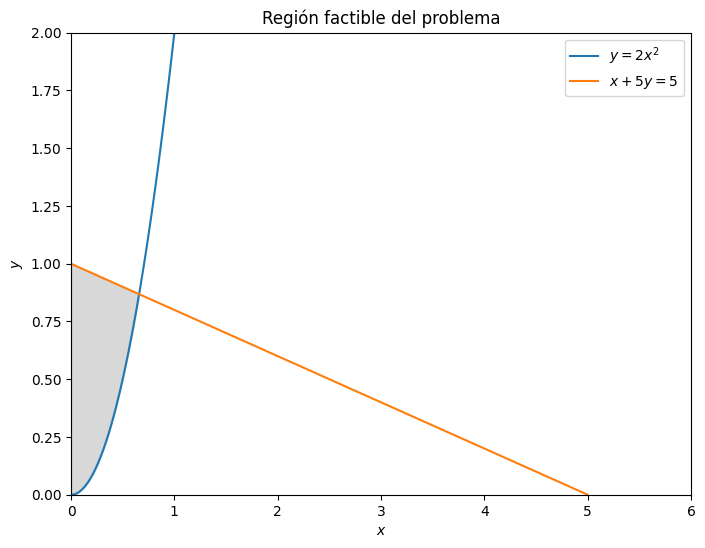

In [36]:
x = np.linspace(0, 5, 400)

# Curvas frontera asociadas a las restricciones
y_parabola = 2 * x**2        # Restricción: y >= 2x^2 (parábola)
y_linea = (5 - x) / 5        # Restricción: x + 5y <= 5 (línea recta)

# Condiciones de no negatividad
y_parabola = np.clip(y_parabola, 0, None)
y_linea = np.clip(y_linea, 0, None)

# Región factible
mask = y_parabola <= y_linea

# Curvas frontera
plt.figure(figsize=(8, 6))
plt.plot(x, y_parabola, label=r'$y = 2x^2$')
plt.plot(x, y_linea, label=r'$x + 5y = 5$')

# Rellenar región factible
plt.fill_between(x, y_parabola, y_linea, where=mask, color='gray', alpha=0.3)

# Configuración del gráfico
plt.xlim(0, 6)
plt.ylim(0, 2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Región factible del problema')
plt.legend()

plt.show()


A continuación, haciendo uso de $sympy$, se procede a obtener los puntos $KKT$ del problema:

In [37]:
# Definimos las variables
x, y, u_1, u_2, u_3, u_4 = sp.symbols('x y u_1 u_2 u_3 u_4')

# Función Objetivo
f = 2*x**2 + 2*y**2 - 2*x*y - 4*x - 6*y

g1 = x + 5*y - 5     # Restricción 1: x + 5y <= 5
g2 = 2*x**2 - y      # Restricción 2: 2x^2 - y <= 0
h1 = -x
h2 = -y

# Lagrangiano
L = f + u_1 * g1 + u_2 * g2 + u_3 * h1 + u_4 * h2

# Derivadas parciales con respecto de x y de y
L_x = sp.diff(L, x)
L_y = sp.diff(L, y)

print("Derivada parcial de L respecto a x:", L_x)
print("Derivada parcial de L respecto a y:", L_y)

# Resolver el sistema de ecuaciones (Condiciones de gradiente + Condiciones de ortogonalidad + Condiciones de factibilidad)
condiciones_min = [
    L_x,          # Condición gradiente
    L_y,          # Condición gradiente
    u_1 * g1, # Condición de ortogonalidad de la restricción 1
    u_2 * g2, # Condición de ortogonalidad de la restricción 2
    u_3 * h1,  # Condición de ortogonalidad de x >= 0
    u_4 * h2,  # Condición de ortogonalidad de y >= 0
]

# Nota de aclaración:  la condición de factibilidad se maneja indirectamente gracias a las condiciones de complementariedad.
# No se necesita indicar explícitamente que las restricciones son desigualdades en el sistema de ecuaciones porque la
# combinación de las ecuaciones y las condiciones de complementariedad permite obtener los mismos resultados que si se
# estuvieran resolviendo desigualdades directamente.

# Resolvemos y obtenemos los puntos
Puntos = sp.solve(condiciones_min, [x, y, u_1, u_2, u_3, u_4], dict=True)

# El siguiente paso es evaluar los puntos en la función objetivo para obtener el óptimo

opt_value = float('inf')  # Inicializamos el valor óptimo como infinito
optimal_solution = None  # Variable para almacenar la solución óptima

puntos = []
puntos_kkt = []
print(Puntos)

# Iteramos sobre todas las soluciones y evaluamos ÚNICAMENTE en puntos KKT, por eficiencia

for sol in Puntos:
    if all (sp.im(sol[var])==0 for var in sol):

        x_val = sp.simplify(sol[x])
        y_val = sp.simplify(sol[y])
        u_1_val = sp.simplify(sol[u_1])
        u_2_val = sp.simplify(sol[u_2])
        u_3_val = sp.simplify(sol[u_3])
        u_4_val = sp.simplify(sol[u_4])
        puntos.append((x_val, y_val, u_1_val, u_2_val, u_3_val, u_4_val))  # Almacena todos los puntos KKT
        #decidimos usar simplify() en vez de evalf() para evitar que nos de dependencia entre los u_i

        # Verifica si el punto KKT es factible
        eps = 1e-8 # Al hacer simplify() y evalf() ocurrió un problema que se detalla en la siguiente caja de código. Básicamente, parece que
        # de alguna forma al evaluar se pierde precisión en las coordenadas de los puntos, de esta manera, para un punto KKT
        # se puede obtener que una restricción evaluada en un punto es positiva.
        # del orden de 10e-16 (prácticamente nulo) y al ser un valor positivo se descartaría como punto KKT. Es por
        # ello que introducimos un épsilon de tolerancia para las restricciones de factibilidad.
        if (g1.subs({x: x_val, y: y_val}).evalf() <= eps\
             and g2.subs({x: x_val, y: y_val}).evalf() <= eps\
             and h1.subs({x: x_val, y: y_val}).evalf() <= eps  # x >=0\
            and h2.subs({x: x_val, y: y_val}).evalf() <= eps # y >= 0\
            and u_1_val >= 0 and u_2_val >= 0 and u_3_val >= 0 and u_4_val >= 0):
            f_value = f.subs({x: x_val, y: y_val}).evalf()
            puntos_kkt.append((x_val, y_val, f_value, u_1_val, u_2_val, u_3_val, u_4_val))  # Almacena los puntos KKT factibles

            # Verifica si es el mínimo óptimo
            if f_value < opt_value:
                opt_value = f_value
                optimal_solution = sol

# Puntos
print("\nTodos los puntos")
for punto in puntos:
    print(f"x = {punto[0]}, y = {punto[1]} u_1 = {punto[2]}, u_2 = {punto[3]}, u_3 = {punto[4]}, u_4 = {punto[5]}")

# Puntos KKT
print("\nPuntos KKT:")
for punto in puntos_kkt:
    print(f"x = {punto[0]}, y = {punto[1]}, f(x, y) = {punto[2]}, u_1 = {punto[3]}, u_2 = {punto[4]}, u_3 = {punto[5]}, u_4 = {punto[6]}")

# Solución óptima
if optimal_solution:
    print(f"\nLa solución óptima es: x = {optimal_solution[x].evalf()}, y = {optimal_solution[y].evalf()}")
    print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {opt_value}")
    print(f"Multiplicadores: u_1 = {optimal_solution[u_1].evalf()}, u_2 = {optimal_solution[u_2].evalf()}, u_3 = {optimal_solution[u_3].evalf()}, u_4 = {optimal_solution[u_4].evalf()}")
else:
    print("No se encontró una solución óptima factible.")


Derivada parcial de L respecto a x: u_1 + 4*u_2*x - u_3 + 4*x - 2*y - 4
Derivada parcial de L respecto a y: 5*u_1 - u_2 - u_4 - 2*x + 4*y - 6
[{u_1: 0, u_2: -u_4 - 6, u_3: -4, x: 0, y: 0}, {u_1: -16, u_2: 0, u_3: 0, u_4: -96, x: 5, y: 0}, {u_1: 0, u_2: -6, u_3: -4, u_4: 0, x: 0, y: 0}, {u_1: 0, u_2: 0, u_3: -7, u_4: 0, x: 0, y: 3/2}, {u_1: 0, u_2: 0, u_3: 0, u_4: -8, x: 1, y: 0}, {u_1: 0, u_2: 0, u_3: 0, u_4: 0, x: 7/3, y: 8/3}, {u_1: 0, u_2: -7/8 - 43/(192*(53/512 + sqrt(687)*I/1152)**(1/3)*(1/2 - sqrt(3)*I/2)) - 1/(-1/8 + (53/512 + sqrt(687)*I/1152)**(1/3)*(1/2 - sqrt(3)*I/2) + 43/(192*(53/512 + sqrt(687)*I/1152)**(1/3)*(1/2 - sqrt(3)*I/2))) - (53/512 + sqrt(687)*I/1152)**(1/3)*(1/2 - sqrt(3)*I/2), u_3: 0, u_4: 0, x: (-43*3**(2/3)/12 + (1 - sqrt(3)*I)*(6 + (-1 + sqrt(3)*I)*(1431 + 12*sqrt(687)*I)**(1/3))*(477 + 4*sqrt(687)*I)**(1/3)/48)/((1 - sqrt(3)*I)*(477 + 4*sqrt(687)*I)**(1/3)), y: (172*3**(2/3) + (-6 + 3**(1/3)*(1 - sqrt(3)*I)*(477 + 4*sqrt(687)*I)**(1/3))*(1 - sqrt(3)*I)*(477 

Se obtiene que la solución óptima se da en el punto (aproximado)

$$
(0.658872343937891,0.868225531212422)
$$

con un valor de la función objetivo (aproximado) de

$$
-6.61308546734879
$$

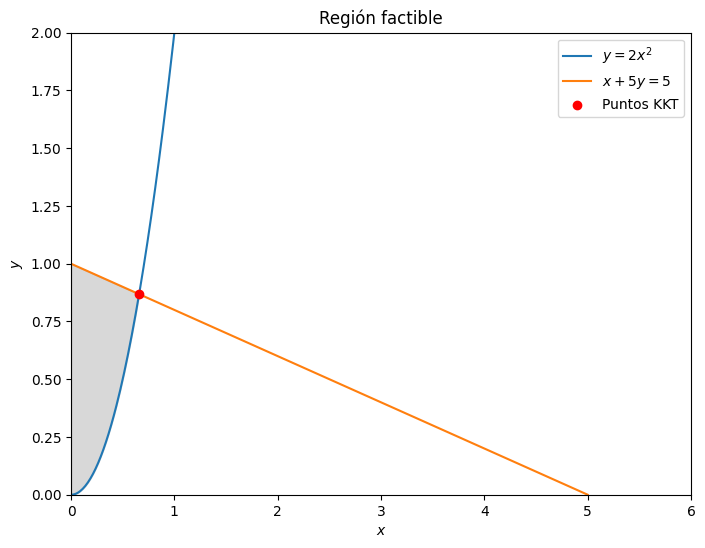

In [38]:
x = np.linspace(0, 5, 400)

# Curvas frontera asociadas a las restricciones
y_parabola = 2 * x**2        # Restricción: y >= 2x^2 (parábola)
y_linea = (5 - x) / 5        # Restricción: x + 5y <= 5 (línea recta)

# Condiciones de no negatividad
y_parabola = np.clip(y_parabola, 0, None)
y_linea = np.clip(y_linea, 0, None)

# Región factible
mask = y_parabola <= y_linea

# Curvas frontera
plt.figure(figsize=(8, 6))
plt.plot(x, y_parabola, label=r'$y = 2x^2$')
plt.plot(x, y_linea, label=r'$x + 5y = 5$')

# Rellenar región factible
plt.fill_between(x, y_parabola, y_linea, where=mask, color='gray', alpha=0.3)

puntos_kkt_x, puntos_kkt_y = zip(*[(punto[0], punto[1]) for punto in puntos_kkt])  # Extraemos los x y y
plt.scatter(puntos_kkt_x, puntos_kkt_y, color='red', label='Puntos KKT', zorder=5)


# Más opciones para el gráfico
plt.xlim(0, 6)
plt.ylim(0, 2)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Región factible')

plt.legend()

plt.show()

Con respecto al problema que hemos mencionado antes, al obtener que el punto no era factible (antes de poner la tolerancia), pensamos que era adecuado comprobar las restricciones para ver qué fallaba. Eso es lo que se hace a continuación, observando que al evaluar en la restricción g1 el punto, se obtiene un valor positivo del orden de $10e-16$.

In [39]:
# Definimos las variables
x, y = sp.symbols('x y')

# Coordenadas del punto KKT factible
x_val = 0.658872343937891
y_val = 0.868225531212422

# Restricciones
g1 = x + 5*y - 5     # Restricción 1: x + 5y <= 5
g2 = 2*x**2 - y      # Restricción 2: 2x^2 - y <= 0

# Evaluación
g1_val = sp.simplify(g1.subs({x: x_val, y: y_val}))
g2_val = sp.simplify(g2.subs({x: x_val, y: y_val}))

print(f"Evaluación de g1 en el punto (x, y) = ({x_val}, {y_val}): g1 = {g1_val}")
print(f"Evaluación de g2 en el punto (x, y) = ({x_val}, {y_val}): g2 = {g2_val}")
print(f"Verificación de x >= 0: {x_val >= 0}")
print(f"Verificación de y >= 0: {y_val >= 0}")


Evaluación de g1 en el punto (x, y) = (0.658872343937891, 0.868225531212422): g1 = 8.88178419700125E-16
Evaluación de g2 en el punto (x, y) = (0.658872343937891, 0.868225531212422): g2 = -9.99200722162641E-16
Verificación de x >= 0: True
Verificación de y >= 0: True


A continuación ponemos el código antiguo $\textbf{sin la tolerancia}$, para que conste que no se encontraba punto factible por el motivo mencionado:

In [40]:
# Definimos las variables
x, y, u_1, u_2, u_3, u_4 = sp.symbols('x y u_1 u_2 u_3 u_4')

# Función Objetivo
f = 2*x**2 + 2*y**2 - 2*x*y - 4*x - 6*y

g1 = x + 5*y - 5     # Restricción 1: x + 5y <= 5
g2 = 2*x**2 - y  # Restricción 2: 2x^2 - y <= 0
h1 = -x
h2 = -y

# Lagrangiano
L = f + u_1 * g1 + u_2 * g2 + u_3 * h1 + u_4 * h2

# Derivadas parciales con respecto de x y de y
L_x = sp.diff(L, x)
L_y = sp.diff(L, y)

print("Derivada parcial de L respecto a x:", L_x)
print("Derivada parcial de L respecto a y:", L_y)

# Resolver el sistema de ecuaciones (Condiciones de gradiente + Condiciones de ortogonalidad + Condiciones de factibilidad)
condiciones_min = [
    L_x,          # Condición gradiente
    L_y,          # Condición gradiente          # Factibilidad (restricción 1)           # Factibilidad (restricción 2)
    u_1 * g1, # Condición de ortogonalidad de la restricción 1
    u_2 * g2, # Condición de ortogonalidad de la restricción 2
    u_3 * h1,  # Condición de ortogonalidad de x >= 0
    u_4 * h2,  # Condición de ortogonalidad de y >= 0
]

# Nota de aclaración:  la condición de factibilidad se maneja indirectamente gracias a las condiciones de complementariedad.
# No se necesita indicar explícitamente que las restricciones son desigualdades en el sistema de ecuaciones porque la
# combinación de las ecuaciones y las condiciones de complementariedad permite obtener los mismos resultados que si se
# estuvieran resolviendo desigualdades directamente.

# Resolvemos y obtenemos los puntos KKT
Puntos = sp.solve(condiciones_min, [x, y, u_1, u_2, u_3, u_4], dict=True)

# El siguiente paso es evaluar los puntos KKT en la función objetivo para obtener el óptimo

opt_value = float('inf')  # Inicializamos el valor óptimo como infinito
optimal_solution = None  # Variable para almacenar la solución óptima

puntos = []
puntos_kkt = []

# Iteramos sobre todas las soluciones y evaluamos ÚNICAMENTE en puntos KKT factibles, por eficiencia
for sol in Puntos:
    #Nos cogemos solo las soluciones reales
    if all (sp.im(sol[var])==0 for var in sol):
        x_val = sp.simplify(sol[x])
        y_val = sp.simplify(sol[y])
        u_1_val = sp.simplify(sol[u_1])
        u_2_val = sp.simplify(sol[u_2])
        u_3_val = sp.simplify(sol[u_3])
        u_4_val = sp.simplify(sol[u_4])
    #f_value = f.subs({x: x_val, y: y_val}).evalf()
        puntos.append((x_val, y_val, u_1_val, u_2_val, u_3_val, u_4_val))  # Almacena todos los puntos KKT

        # Verifica si el punto es KKT
        if (g1.subs({x: x_val, y: y_val}).evalf() <= 0\
            and g2.subs({x: x_val, y: y_val}).evalf() <= 0\
            and h1.subs({x: x_val, y: y_val}).evalf() <= eps  # x >=0\
            and h2.subs({x: x_val, y: y_val}).evalf() <= eps # y >= 0\
            and u_1_val >= 0 and u_2_val >= 0 and u_3_val >= 0 and u_4_val >= 0):
            f_value = f.subs({x: x_val, y: y_val}).evalf()
            puntos_kkt.append((x_val, y_val, f_value, u_1_val, u_2_val, u_3_val, u_4_val))  # Almacena los puntos KKT factibles

            # Verifica si es el mínimo óptimo
            if f_value < opt_value:
                opt_value = f_value
                optimal_solution = sol

# Puntos
print("\nTodos los puntos:")
for punto in puntos:
    print(f"x = {punto[0]}, y = {punto[1]} u_1 = {punto[2]}, u_2 = {punto[3]}, u_3 = {punto[4]}, u_4 = {punto[5]}")

# Puntos KKT factibles
print("\nPuntos KKT:")
for punto in puntos_kkt:
    print(f"x = {punto[0]}, y = {punto[1]}, f(x, y) = {punto[2]}, u_1 = {punto[3]}, u_2 = {punto[4]}, u_3 = {punto[5]}, u_4 = {punto[6]}")

# Solución óptima
if optimal_solution:
    print(f"\nLa solución óptima es: x = {optimal_solution[x].evalf()}, y = {optimal_solution[y].evalf()}")
    print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {opt_value}")
    print(f"Multiplicadores: u_1 = {optimal_solution[u_1].evalf()}, u_2 = {optimal_solution[u_2].evalf()}, u_3 = {optimal_solution[u_3].evalf()}, u_4 = {optimal_solution[u_4].evalf()}")
else:
    print("No se encontró una solución óptima factible.")

Derivada parcial de L respecto a x: u_1 + 4*u_2*x - u_3 + 4*x - 2*y - 4
Derivada parcial de L respecto a y: 5*u_1 - u_2 - u_4 - 2*x + 4*y - 6

Todos los puntos:
x = 5, y = 0 u_1 = -16, u_2 = 0, u_3 = 0, u_4 = -96
x = 0, y = 0 u_1 = 0, u_2 = -6, u_3 = -4, u_4 = 0
x = 0, y = 3/2 u_1 = 0, u_2 = 0, u_3 = -7, u_4 = 0
x = 1, y = 0 u_1 = 0, u_2 = 0, u_3 = 0, u_4 = -8
x = 7/3, y = 8/3 u_1 = 0, u_2 = 0, u_3 = 0, u_4 = 0
x = 0, y = 1 u_1 = 2/5, u_2 = 0, u_3 = -28/5, u_4 = 0
x = 35/31, y = 24/31 u_1 = 32/31, u_2 = 0, u_3 = 0, u_4 = 0
x = -sqrt(201)/20 - 1/20, y = sqrt(201)/100 + 101/100 u_1 = 31/250 - 2869*sqrt(201)/50250, u_2 = -731*sqrt(201)/5025 - 31/25, u_3 = 0, u_4 = 0
x = -1/20 + sqrt(201)/20, y = 101/100 - sqrt(201)/100 u_1 = 31/250 + 2869*sqrt(201)/50250, u_2 = -31/25 + 731*sqrt(201)/5025, u_3 = 0, u_4 = 0

Puntos KKT:
No se encontró una solución óptima factible.


b) Automatízalo en la medida de lo posible para aplicarlo a otros problemas, por ejemplo, los siguientes que hemos visto en los apuntes de teoría:

Podemos automatizar el proceso llevado a cabo en el apartado a) para resolver de manera general problemas de minimización buscando los puntos $KKT$ y evaluándolos en la función objetivo.

Pasando como argumentos el lagrangiano, las condiciones $KKT$, las variables y los multiplicadores $u_i$ que se introducen por cada restricción, podemos automatizar el proceso de la siguiente manera:

In [41]:
def resolver_kkt(lagrangiano, restricciones, condiciones_kkt, variables, multiplicadores, eps):
    # Sistema de ecuaciones
    soluciones = sp.solve(condiciones_kkt, variables + multiplicadores, dict=True)

    valor_optimo = float('inf') # Inicialización del óptimo
    solucion_optima = None
    puntos = []
    puntos_kkt = []
    eps = 1e-8  # Tolerancia para la factibilidad

    for sol in soluciones:
        # Solo cogemos las soluciones reales
        if all (sp.im(sol[var])==0 for var in sol):
            # Se evalúan las variables en la solución actual
            valores_solucion = {var: sp.simplify(sol[var]) for var in variables + multiplicadores}
            puntos.append(valores_solucion)

            # Verificación de si el punto es factible
            factible = (all(cond.subs(valores_solucion).evalf() <= eps for cond in condiciones_kkt) and
                        all(valores_solucion[u] >= 0 for u in multiplicadores)) and\
                        all(rest.subs(valores_solucion).evalf() <= eps for rest in restricciones)
                        #and all(valores_solucion[var] >= 0 for var in variables)

            if factible:
                valor_objetivo = lagrangiano.subs(valores_solucion).evalf()
                puntos_kkt.append((valores_solucion, valor_objetivo))

                # Si es la mejor solución encontrada, se actualiza el valor y la solución
                if valor_objetivo < valor_optimo:
                    valor_optimo = valor_objetivo
                    solucion_optima = valores_solucion

    # Puntos KKT
    print("\nTodos los puntos:")
    for punto in puntos:
        print(punto)

    # Puntos KKT factibles
    print("\nPuntos KKT:")
    for punto, valor in puntos_kkt:
        print(f"Punto: {punto}, f(x, y) = {valor}")

    # Solución óptima
    if solucion_optima:
        print(f"\nLa solución óptima es: {solucion_optima}")
        print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {valor_optimo}")
    else:
        print("No se encontró una solución óptima factible.")


Una vez automatizado el proceso, pasamos a resolver $P_1$ y $P_2$

$$
P_1: \quad \text{minimizar } \quad (x - 3)^2 + (y - 2)^2
$$
sujeto a:
$$
x^2 + y^2 \leq 5
$$
$$
x + 2y \leq 4
$$
$$
x, y \geq 0
$$


Primero de todo podemos visualizar la región factible:

C:\Users\Propietario\AppData\Local\Temp\ipykernel_1628\2737245167.py:4: RuntimeWarning: invalid value encountered in sqrt
  y1 = np.sqrt(5 - x**2)       # Restricción: x^2 + y^2 <= 5 (circunferencia)


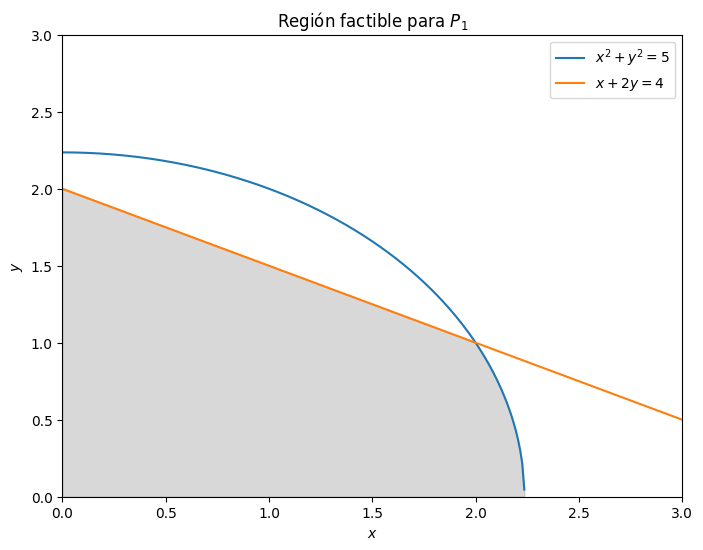

In [42]:
x = np.linspace(0, 4, 400)

# Curvas frontera asociadas a restricciones
y1 = np.sqrt(5 - x**2)       # Restricción: x^2 + y^2 <= 5 (circunferencia)
y2 = (4 - x) / 2             # Restricción: x + 2y <= 4 (línea recta)

plt.figure(figsize=(8, 6))

# Plot de las curvas frontera
plt.plot(x, y1, label=r'$x^2 + y^2 = 5$')
plt.plot(x, y2, label=r'$x + 2y = 4$')


# Región factible
plt.fill_between(x, np.minimum(y1, y2), where=(y1 >= 0) & (y2 >= 0), color='gray', alpha=0.3)


plt.xlim(0, 3)
plt.ylim(0, 3)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Región factible para $P_1$')
plt.legend()

plt.show()

Y podemos resolverlo de forma automatizada con la función programada:

In [43]:
# Variables y multiplicadores de Lagrange para el problema P_1
x, y, u_1, u_2, u_3, u_4 = sp.symbols('x y u_1 u_2 u_3 u_4')

# Función Objetivo para P_1
f_p1 = (x - 3)**2 + (y - 2)**2

# Restricciones para P_1
g1_p1 = x**2 + y**2 - 5    # Restricción 1: x^2 + y^2 <= 5
g2_p1 = x + 2*y - 4
h1 = -x
h2 = -y     # Restricción 2: x + 2y <= 4

restricciones_p1 = [g1_p1, g2_p1, h1, h2]

# Lagrangiano para P_1
lagrangiano_p1 = f_p1 + u_1 * g1_p1 + u_2 * g2_p1 + u_3 * h1 + u_4 * h2

# Derivadas del Lagrangiano respecto de x e y
L_x_p1 = sp.diff(lagrangiano_p1, x)
L_y_p1 = sp.diff(lagrangiano_p1, y)

# Condiciones de KKT para P_1
condiciones_kkt_p1 = [
    L_x_p1, L_y_p1,    # Derivadas del Lagrangiano     # Restricciones de factibilidad
    u_1 * g1_p1,       # Ortogonalidad para g1
    u_2 * g2_p1,       # Ortogonalidad para g2
    u_3 * h1,        # Ortogonalidad para x >= 0
    u_4 * h2         # Ortogonalidad para y >= 0
]

# Llamar a la función para resolver P_1
print("Resolviendo P_1:")
resolver_kkt(lagrangiano_p1, restricciones_p1, condiciones_kkt_p1, [x, y], [u_1, u_2, u_3, u_4], 10**(-8))

Resolviendo P_1:

Todos los puntos:
{x: -2/5, y: 11/5, u_1: -7/3, u_2: 74/15, u_3: 0, u_4: 0}
{x: 4, y: 0, u_1: 0, u_2: -2, u_3: 0, u_4: -8}
{x: 0, y: 0, u_1: 0, u_2: 0, u_3: -6, u_4: -4}
{x: 0, y: 2, u_1: 0, u_2: 0, u_3: -6, u_4: 0}
{x: 3, y: 0, u_1: 0, u_2: 0, u_3: 0, u_4: -4}
{x: 3, y: 2, u_1: 0, u_2: 0, u_3: 0, u_4: 0}
{x: 12/5, y: 4/5, u_1: 0, u_2: 6/5, u_3: 0, u_4: 0}
{x: 2, y: 1, u_1: 1/3, u_2: 2/3, u_3: 0, u_4: 0}
{x: 0, y: -sqrt(5), u_1: -1 - 2*sqrt(5)/5, u_2: 0, u_3: -6, u_4: 0}
{x: 0, y: sqrt(5), u_1: -1 + 2*sqrt(5)/5, u_2: 0, u_3: -6, u_4: 0}
{x: sqrt(5), y: 0, u_1: -1 + 3*sqrt(5)/5, u_2: 0, u_3: 0, u_4: -4}
{x: 3*sqrt(65)/13, y: 2*sqrt(65)/13, u_1: -1 + sqrt(65)/5, u_2: 0, u_3: 0, u_4: 0}
{x: -sqrt(5), y: 0, u_1: -3*sqrt(5)/5 - 1, u_2: 0, u_3: 0, u_4: -4}
{x: -3*sqrt(65)/13, y: -2*sqrt(65)/13, u_1: -sqrt(65)/5 - 1, u_2: 0, u_3: 0, u_4: 0}

Puntos KKT:
Punto: {x: 2, y: 1, u_1: 1/3, u_2: 2/3, u_3: 0, u_4: 0}, f(x, y) = 2.00000000000000

La solución óptima es: {x: 2, y: 1, u_

Se obtiene que la solución óptima se da en el punto (aproximado)

$$
(2,1)
$$

con un valor de la función objetivo de

$$
f(2,1) = 2
$$

A modo de complemento, podemos resolverlo como en el apartado a) de la siguiente forma:

In [44]:
# Definimos las variables
x, y, u_1, u_2, u_3, u_4 = sp.symbols('x y u_1 u_2 u_3 u_4')

# Función Objetivo
f = (x - 3)**2 + (y - 2)**2

# Restricciones
g1 = x**2 + y**2 - 5     # Restricción 1: x^2 + y^2 <= 5
g2 = x + 2*y - 4         # Restricción 2: x + 2y <= 4
h1 = -x
h2 = -y


# Lagrangiano
L = f + u_1 * g1 + u_2 * g2 + u_3 * h1 + u_4 * h2

# Derivadas parciales con respecto de x y de y
L_x = sp.diff(L, x)
L_y = sp.diff(L, y)

print("Derivada parcial de L respecto a x:", L_x)
print("Derivada parcial de L respecto a y:", L_y)

# Resolver el sistema de ecuaciones (L_x = 0, L_y = 0, condiciones de complementariedad y factibilidad)
condiciones_min = [
    L_x,          # Derivada con respecto a x
    L_y,          # Derivada con respecto a y          # Restricción 1          # Restricción 2
    u_1 * g1, # Condición de complementariedad de la restricción 1
    u_2 * g2, # Condición de complementariedad de la restricción 2
    u_3 * h1,  # Condición de complementariedad de x >= 0
    u_4 * h2   # Condición de complementariedad de y >= 0
]

# Resolvemos y obtenemos los puntos KKT
Puntos = sp.solve(condiciones_min, [x, y, u_1, u_2, u_3, u_4], dict=True)
print(Puntos)

# El siguiente paso es evaluar los puntos KKT en la función objetivo para obtener el óptimo

opt_value = float('inf')  # Inicializamos el valor óptimo como infinito
optimal_solution = None  # Variable para almacenar la solución óptima

puntos = []
puntos_kkt = []

# Iteramos sobre todas las soluciones y evaluamos ÚNICAMENTE en puntos KKT factibles, por eficiencia
for sol in Puntos:
    if all (sp.im(sol[var])==0 for var in sol):
        x_val = sp.simplify(sol[x])
        y_val = sp.simplify(sol[y])
        u_1_val = sp.simplify(sol[u_1])
        u_2_val = sp.simplify(sol[u_2])
        u_3_val = sp.simplify(sol[u_3])
        u_4_val = sp.simplify(sol[u_4])
        #f_value = f.subs({x: x_val, y: y_val}).evalf()
        puntos.append((x_val, y_val, u_1_val, u_2_val, u_3_val, u_4_val))  # Almacena todos los puntos KKT

        # Verifica si el punto KKT es factible
        eps = 1e-8
        if (g1.subs({x: x_val, y: y_val}).evalf() <= eps #restricción 1\
            and g2.subs({x: x_val, y: y_val}).evalf() <= eps\
            and h1.subs({x: x_val, y: y_val}).evalf() <= eps  # x >=0\
            and h2.subs({x: x_val, y: y_val}).evalf() <= eps # y >= 0\
            and u_1_val >= 0 and u_2_val >= 0 and u_3_val >= 0 and u_4_val >= 0):
            f_value = f.subs({x: x_val, y: y_val}).evalf()
            puntos_kkt.append((x_val, y_val, f_value, u_1_val, u_2_val, u_3_val, u_4_val))  # Almacena los puntos KKT factibles

            # Verifica si es el mínimo óptimo
            if f_value < opt_value:
                opt_value = f_value
                optimal_solution = sol

# Puntos
for punto in puntos:
    print(f"x = {punto[0]}, y = {punto[1]}, con u_1 = {punto[2]}, u_2 = {punto[3]}, u_3 = {punto[4]}, u_4 = {punto[5]}")

# Puntos KKT
print("\nPuntos KKT")
for punto in puntos_kkt:
    print(f"x = {punto[0]}, y = {punto[1]}, con f(x, y) = {punto[2]}, u_1 = {punto[3]}, u_2 = {punto[4]}, u_3 = {punto[5]}, u_4 = {punto[6]}")

# Solución óptima
if optimal_solution:
    print(f"\nLa solución óptima es: x = {optimal_solution[x].evalf()}, y = {optimal_solution[y].evalf()}")
    print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {opt_value}")
    print(f"Multiplicadores: u_1 = {optimal_solution[u_1].evalf()}, u_2 = {optimal_solution[u_2].evalf()}, u_3 = {optimal_solution[u_3].evalf()}, u_4 = {optimal_solution[u_4].evalf()}")
else:
    print("No se encontró una solución óptima factible.")

Derivada parcial de L respecto a x: 2*u_1*x + u_2 - u_3 + 2*x - 6
Derivada parcial de L respecto a y: 2*u_1*y + 2*u_2 - u_4 + 2*y - 4
[{u_1: -7/3, u_2: 74/15, u_3: 0, u_4: 0, x: -2/5, y: 11/5}, {u_1: 0, u_2: -2, u_3: 0, u_4: -8, x: 4, y: 0}, {u_1: 0, u_2: 0, u_3: -6, u_4: -4, x: 0, y: 0}, {u_1: 0, u_2: 0, u_3: -6, u_4: 0, x: 0, y: 2}, {u_1: 0, u_2: 0, u_3: 0, u_4: -4, x: 3, y: 0}, {u_1: 0, u_2: 0, u_3: 0, u_4: 0, x: 3, y: 2}, {u_1: 0, u_2: 6/5, u_3: 0, u_4: 0, x: 12/5, y: 4/5}, {u_1: 1/3, u_2: 2/3, u_3: 0, u_4: 0, x: 2, y: 1}, {u_1: -1 - 2*sqrt(5)/5, u_2: 0, u_3: -6, u_4: 0, x: 0, y: -sqrt(5)}, {u_1: -1 + 2*sqrt(5)/5, u_2: 0, u_3: -6, u_4: 0, x: 0, y: sqrt(5)}, {u_1: -1 + 3*sqrt(5)/5, u_2: 0, u_3: 0, u_4: -4, x: sqrt(5), y: 0}, {u_1: -1 + sqrt(65)/5, u_2: 0, u_3: 0, u_4: 0, x: 3*sqrt(65)/13, y: 2*sqrt(65)/13}, {u_1: -3*sqrt(5)/5 - 1, u_2: 0, u_3: 0, u_4: -4, x: -sqrt(5), y: 0}, {u_1: -sqrt(65)/5 - 1, u_2: 0, u_3: 0, u_4: 0, x: -3*sqrt(65)/13, y: -2*sqrt(65)/13}]
x = -2/5, y = 11/5, con

C:\Users\Propietario\AppData\Local\Temp\ipykernel_1628\767594826.py:4: RuntimeWarning: invalid value encountered in sqrt
  y1 = np.sqrt(5 - x**2)       # Restricción: x^2 + y^2 <= 5 (circunferencia)


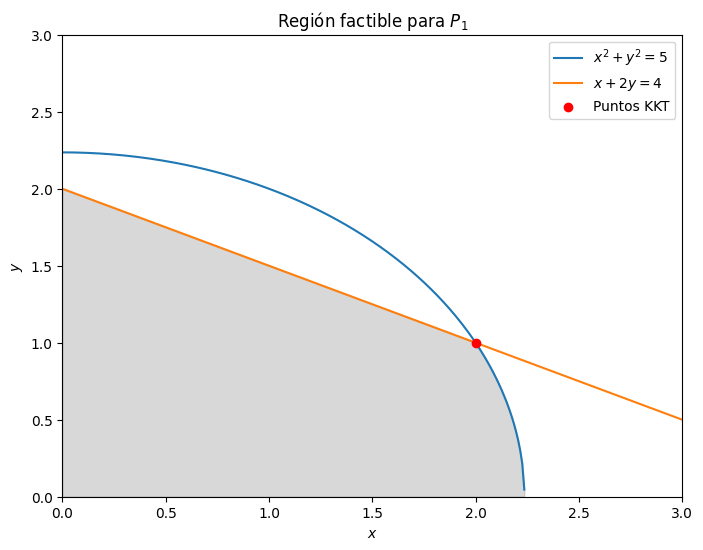

In [45]:
x = np.linspace(0, 4, 400)

# Curvas frontera asociadas a restricciones
y1 = np.sqrt(5 - x**2)       # Restricción: x^2 + y^2 <= 5 (circunferencia)
y2 = (4 - x) / 2             # Restricción: x + 2y <= 4 (línea recta)

plt.figure(figsize=(8, 6))

# Plot de las curvas frontera
plt.plot(x, y1, label=r'$x^2 + y^2 = 5$')
plt.plot(x, y2, label=r'$x + 2y = 4$')


# Región factible
plt.fill_between(x, np.minimum(y1, y2), where=(y1 >= 0) & (y2 >= 0), color='gray', alpha=0.3)

puntos_kkt_x, puntos_kkt_y = zip(*[(punto[0], punto[1]) for punto in puntos_kkt])  # Extraemos los x y y
plt.scatter(puntos_kkt_x, puntos_kkt_y, color='red', label='Puntos KKT', zorder=5)

plt.xlim(0, 3)
plt.ylim(0, 3)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Región factible para $P_1$')
plt.legend()

plt.show()



Pasamos ahora a resolver el problema $P_2$.

$$
P_2: \quad \text{minimizar } \quad 2x - y
$$
sujeto a:
$$
-x^2 + y \leq 0
$$
$$
(x - 1)^2 + y - 5 \leq 0
$$
$$
y \geq 0
$$


Como antes, podemos primero observar la región factible:

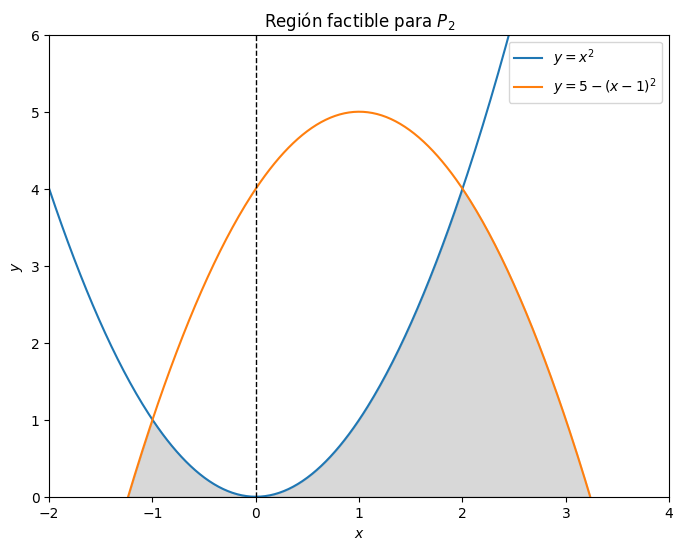

In [46]:
x = np.linspace(-2, 4, 400)

# Curvas frontera de las restricciones
y1 = x**2                     # Restricción: y <= x^2
y2 = 5 - (x - 1)**2           # Restricción: y <= 5 - (x - 1)^2

# Consideramos solo los valores de y2 donde es no negativa
y2_valid = np.copy(y2)
y2_valid[y2_valid < 0] = np.nan

# La región factible es donde y >= 0 y y <= min(y1, y2_valid)
y_lower = np.zeros_like(x)
y_upper = np.minimum(y1, y2_valid)

# Región factible
feasible_mask = (y_upper >= y_lower) & (~np.isnan(y_upper))

# Graficamos
plt.figure(figsize=(8, 6))

# Curvas frontera
plt.plot(x, y1, label=r'$y = x^2$')
plt.plot(x, y2, label=r'$y = 5 - (x - 1)^2$')

# Rellenar la región factible
plt.fill_between(x, y_lower, y_upper, where=feasible_mask, color='gray', alpha=0.3)

# Vertical x = 0 para distinguir cuadrante
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Ajustes
plt.xlim(-2, 4)
plt.ylim(0, 6)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Región factible para $P_2$')
plt.legend()
plt.show()

Y podemos resolverlo de forma automatizada:

In [47]:
# Definir las variables y multiplicadores de Lagrange para el problema P_2
x, y, u_1, u_2, u_3 = sp.symbols('x y u_1 u_2 u_3')

# Función Objetivo para P_2
f_p2 = 2*x - y

# Restricciones para P_2
g1_p2 = -x**2 + y         # Restricción 1: -x^2 + y <= 0
g2_p2 = (x - 1)**2 + y - 5 # Restricción 2: (x - 1)^2 + y - 5 <= 0
h1_p2 = -y

restricciones_p2 = [g1_p2, g2_p2, h1_p2]
multiplicadores_p2 = [u_1, u_2, u_3]


# Lagrangiano para P_2
lagrangiano_p2 = f_p2 + u_1 * g1_p2 + u_2 * g2_p2 + u_3 * h1_p2

# Derivadas del Lagrangiano respecto de x e y
L_x_p2 = sp.diff(lagrangiano_p2, x)
L_y_p2 = sp.diff(lagrangiano_p2, y)

# Condiciones de KKT para P_2
condiciones_kkt_p2 = [
    L_x_p2, L_y_p2,   # Derivadas del Lagrangiano
    u_1 * g1_p2,      # Ortogonalidad para g1
    u_2 * g2_p2,      # Ortogonalidad para g2
    u_3 * h1_p2        # Ortogonalidad para y >= 0
]

# Llamar a la función para resolver P_2
print("Resolviendo P_2:")
resolver_kkt(lagrangiano_p2, restricciones_p2, condiciones_kkt_p2, [x, y], [u_1, u_2, u_3], 10**(-8))

Resolviendo P_2:

Todos los puntos:
{x: 0, y: 4, u_1: 0, u_2: 1, u_3: 0}
{x: 1 + sqrt(5), y: 0, u_1: 0, u_2: -sqrt(5)/5, u_3: -1 - sqrt(5)/5}
{x: 1 - sqrt(5), y: 0, u_1: 0, u_2: sqrt(5)/5, u_3: -1 + sqrt(5)/5}
{x: -1, y: 1, u_1: 1/3, u_2: 2/3, u_3: 0}
{x: 2, y: 4, u_1: 2/3, u_2: 1/3, u_3: 0}
{x: 1, y: 1, u_1: 1, u_2: 0, u_3: 0}

Puntos KKT:
Punto: {x: -1, y: 1, u_1: 1/3, u_2: 2/3, u_3: 0}, f(x, y) = -3.00000000000000
Punto: {x: 2, y: 4, u_1: 2/3, u_2: 1/3, u_3: 0}, f(x, y) = 0
Punto: {x: 1, y: 1, u_1: 1, u_2: 0, u_3: 0}, f(x, y) = 1.00000000000000

La solución óptima es: {x: -1, y: 1, u_1: 1/3, u_2: 2/3, u_3: 0}
Valor de la función objetivo en la solución óptima: f(x, y) = -3.00000000000000


Obtenemos que la solución óptima se da en el punto $$(-1,1)$$ con un valor de la función objetivo de $$f(-1,1) = -3$$

A modo de complemento, lo podemos resolver como en el apartado a):

In [48]:
# Definimos las variables
x, y, u_1, u_2, u_3 = sp.symbols('x y u_1 u_2 u_3')

# Definimos la función objetivo
f = 2*x - y

# Definimos las restricciones
g1 = -x**2 + y         # Restricción 1: -x^2 + y <= 0
g2 = (x - 1)**2 + y - 5  # Restricción 2: (x - 1)^2 + y - 5 <= 0
h1 = -y
# Lagrangiana
L = f + u_1 * g1 + u_2 * g2 + u_3 * h1

# Derivadas parciales de la Lagrangiana con respecto a x y de y
L_x = sp.diff(L, x)
L_y = sp.diff(L, y)

# Imprimir las derivadas parciales
print("Derivada parcial de L respecto a x:", L_x)
print("Derivada parcial de L respecto a y:", L_y)

# Resolver el sistema de ecuaciones (L_x = 0, L_y = 0, condiciones de complementariedad y factibilidad)
condiciones_min = [
    L_x,          # Derivada con respecto a x
    L_y,          # Derivada con respecto a y
    u_1 * g1, # Condición de complementariedad de la restricción 1
    u_2 * g2, # Condición de complementariedad de la restricción 2
    u_3 * h1  # Condición de complementariedad de la restricción 3
]

# Resolvemos y obtenemos los puntos KKT
Puntos = sp.solve(condiciones_min, [x, y, u_1, u_2, u_3], dict=True)

# El siguiente paso es evaluar los puntos KKT en la función objetivo para obtener el óptimo

opt_value = float('inf')  # Inicializamos el valor óptimo como infinito
optimal_solution = None  # Variable para almacenar la solución óptima

puntos = []
puntos_kkt = []

# Iteramos sobre todas las soluciones y evaluamos ÚNICAMENTE en puntos KKT factibles, por eficiencia
for sol in Puntos:
    if all (sp.im(sol[var])==0 for var in sol):
        x_val = sp.simplify(sol[x])
        y_val = sp.simplify(sol[y])
        u_1_val = sp.simplify(sol[u_1])
        u_2_val = sp.simplify(sol[u_2])
        u_3_val = sp.simplify(sol[u_3])
    #f_value = f.subs({x: x_val, y: y_val}).evalf()
    puntos.append((x_val, y_val, u_1_val, u_2_val, u_3_val))  # Almacena todos los puntos KKT

    # Verifica si el punto KKT es factible
    eps = 1e-8
    if (g1.subs({x: x_val, y: y_val}).evalf() <= eps and\
        g2.subs({x: x_val, y: y_val}).evalf() <= eps and\
        h1.subs({x: x_val, y: y_val}).evalf() <= eps\
        and u_1_val >= 0 and u_2_val >= 0 and u_3_val >= 0):
        f_value = f.subs({x: x_val, y: y_val}).evalf()
        puntos_kkt.append((x_val, y_val, f_value, u_1_val, u_2_val, u_3_val))  # Almacena los puntos KKT factibles

        # Verifica si es el mínimo óptimo
        if f_value < opt_value:
            opt_value = f_value
            optimal_solution = sol

# Puntos
print("\nTodos los puntos:")
for punto in puntos:
    print(f"x = {punto[0]}, y = {punto[1]}, con u_1 = {punto[2]}, u_2 = {punto[3]}, u_3 = {punto[4]}")

# Puntos KKT
print("\nPuntos KKT:")
for punto in puntos_kkt:
    print(f"x = {punto[0]}, y = {punto[1]}, con f(x, y) = {punto[2]}, u_1 = {punto[3]}, u_2 = {punto[4]}, u_3 = {punto[5]}")

# Solución óptima
if optimal_solution:
    print(f"\nLa solución óptima es: x = {optimal_solution[x].evalf()}, y = {optimal_solution[y].evalf()}")
    print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {opt_value}")
    print(f"Multiplicadores: u_1 = {optimal_solution[u_1].evalf()}, u_2 = {optimal_solution[u_2].evalf()}, u_3 = {optimal_solution[u_3].evalf()}")
else:
    print("No se encontró una solución óptima factible.")

Derivada parcial de L respecto a x: -2*u_1*x + u_2*(2*x - 2) + 2
Derivada parcial de L respecto a y: u_1 + u_2 - u_3 - 1

Todos los puntos:
x = 0, y = 4, con u_1 = 0, u_2 = 1, u_3 = 0
x = 1 + sqrt(5), y = 0, con u_1 = 0, u_2 = -sqrt(5)/5, u_3 = -1 - sqrt(5)/5
x = 1 - sqrt(5), y = 0, con u_1 = 0, u_2 = sqrt(5)/5, u_3 = -1 + sqrt(5)/5
x = -1, y = 1, con u_1 = 1/3, u_2 = 2/3, u_3 = 0
x = 2, y = 4, con u_1 = 2/3, u_2 = 1/3, u_3 = 0
x = 1, y = 1, con u_1 = 1, u_2 = 0, u_3 = 0

Puntos KKT:
x = -1, y = 1, con f(x, y) = -3.00000000000000, u_1 = 1/3, u_2 = 2/3, u_3 = 0
x = 2, y = 4, con f(x, y) = 0, u_1 = 2/3, u_2 = 1/3, u_3 = 0
x = 1, y = 1, con f(x, y) = 1.00000000000000, u_1 = 1, u_2 = 0, u_3 = 0

La solución óptima es: x = -1.00000000000000, y = 1.00000000000000
Valor de la función objetivo en la solución óptima: f(x, y) = -3.00000000000000
Multiplicadores: u_1 = 0.333333333333333, u_2 = 0.666666666666667, u_3 = 0


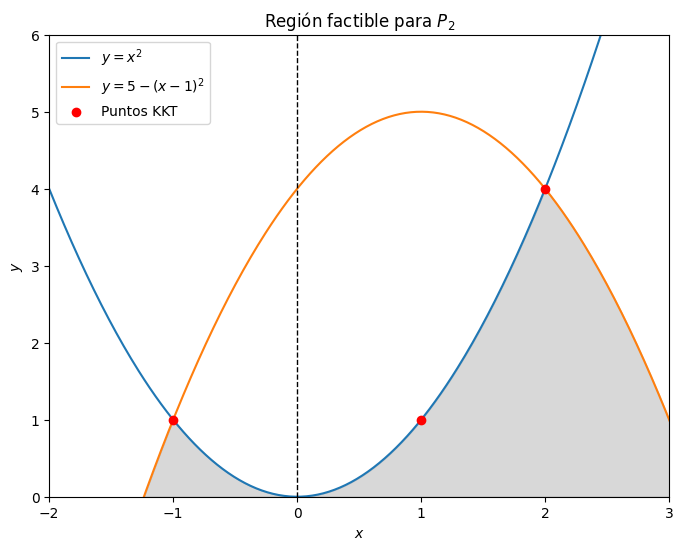

In [49]:
x = np.linspace(-2, 4, 400)

# Curvas frontera de las restricciones
y1 = x**2                     # Restricción: y <= x^2
y2 = 5 - (x - 1)**2           # Restricción: y <= 5 - (x - 1)^2

# Consideramos solo los valores de y2 donde es no negativa
y2_valid = np.copy(y2)
y2_valid[y2_valid < 0] = np.nan

# La región factible es donde y >= 0 y y <= min(y1, y2_valid)
y_lower = np.zeros_like(x)
y_upper = np.minimum(y1, y2_valid)

# Región factible
feasible_mask = (y_upper >= y_lower) & (~np.isnan(y_upper))

# Graficamos
plt.figure(figsize=(8, 6))

# Curvas frontera
plt.plot(x, y1, label=r'$y = x^2$')
plt.plot(x, y2, label=r'$y = 5 - (x - 1)^2$')

# Rellenar la región factible
plt.fill_between(x, y_lower, y_upper, where=feasible_mask, color='gray', alpha=0.3)

puntos_kkt_x, puntos_kkt_y = zip(*[(punto[0], punto[1]) for punto in puntos_kkt])  # Extraemos los x y y
plt.scatter(puntos_kkt_x, puntos_kkt_y, color='red', label='Puntos KKT', zorder=5)

# Vertical x = 0 para distinguir cuadrante
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.xlim(-2, 3)
plt.ylim(0, 6)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Región factible para $P_2$')
plt.legend()

plt.show()


c) Resuelve alguno de los problemas en papel, siguiendo el método que hemos comentado en clase.

Se va a resolver el problema:

$$
\begin{aligned}
    &\min \quad x - 10y \\
    &\text{s.a.} \quad 
    -x^2 + y \leq 0, \\
    &\quad \quad \quad x^2 y^2 - 1 \leq 0.
\end{aligned}
$$


Formulación del Lagrangiano:

$$
\mathcal{L}(x, y, u_1, u_2) = x - 10y + \sum_{i=1}^2 u_i g_i(x, y) = x - 10y + u_1(-x^2 + y) + u_2(x^2y^2 - 1)
$$

con su respectivo gradiente:

$$
\nabla \mathcal{L} =
\begin{bmatrix}
1 - 2xu_1 + 2xy^2u_2 \\
-10 + u_1 + 2x^2yu_2
\end{bmatrix}
$$

Pasemos al análisis de casos, sustituyendo en el Lagrangiano valores para $u_i = 0$ o considerando $u_i \neq 0$.

$\textbf{Caso 1}: u_1 = u_2 = 0$

$$
\begin{cases}
1 = 0 \\
-10 = 0
\end{cases}
$$

Lo que implica que esta situación es imposible.


$\textbf{Caso 2: } u_1 \neq 0, u_2 = 0$

$$
\begin{cases}
1 - 2xu_1 + 2xy^2u_2 = 0 & \implies 1 - 2xu_1 = 0 \quad \text{(como } u_2 = 0) \\
-10 + u_1 + 2x^2yu_2 = 0 & \implies -10 + u_1 = 0
\end{cases}
$$
$$
u_1 = 10, \quad x = \frac{1}{20}, \quad \text{y de la restricción:} \, -x^2 + y = 0 \implies y = x^2
$$

Sustituyendo $ x = \frac{1}{20} \implies y = \left( \frac{1}{20} \right)^2 = \frac{1}{400}$

El punto KKT es:
$$
(x, y) = \left( \frac{1}{20}, \frac{1}{400} \right), \quad \text{con } u_1 = 10, \, u_2 = 0
$$

$\textbf{Caso 3: } u_1 = 0, u_2 \neq 0$

$$
\begin{cases}
1 - 2xu_1 + 2xy^2u_2 = 0 \\
-10 + u_1 + 2x^2yu_2 = 0 \\
x^2y^2-1 = 0 
\end{cases}
$$
Se tiene que
$$
\begin{cases}
1 + 2xy^2u_2 = 0 \\
-10 + 2x^2yu_2 = 0 \\
x^2y^2 = 1
\end{cases}
$$

Multiplicando la primera ecuación por $x$ y la segunda por $y$:
$$
\begin{cases}
x+2x^2y^2u_2=0 \\
-10y+2x^2y^2u_2=0 \\
x^2y^2=1
\end{cases}
$$

Usando $x^2y^2=1$:

$$
\begin{cases}
x+2u_2=0 \\
-10y+2u_2=0 \\
x^2y^2=1
\end{cases}
$$

Por tanto se tiene que 

$$
\begin{cases}
x = -2u_2 \\
y = \frac{u_2}{5} \\
x^2y^2=1
\end{cases}
$$

Resolviendo els sitema para $u_2$ se obtiene que 

$$
u_2 = \frac{\sqrt{10}}{2}\text{ ó } u_2 = -\frac{\sqrt{10}}{2}
$$

Si $u_2 = \frac{\sqrt{10}}{2}$, entonces

$$
\begin{cases}
x = -\sqrt{10}\\
y = \frac{\sqrt{10}}{10}
\end{cases}
$$

y tenemos un punto KKT:

$$(x,y) = (-\sqrt{10},\frac{\sqrt{10}}{10})$$

Por otro lado si $u_2 = -\frac{\sqrt{10}}{2}$, entonces se tiene que $u_2 < 0 $ lo que no nos lleva a un punto KKT.

$\textbf{Caso 4: } u_1 \neq 0, u_2 \neq 0$

$$
\begin{cases}
1 - 2xu_1 + 2xy^2u_2 = 0, \\
-10 + u_1 + 2x^2yu_2 = 0, \\
-x^2 + y = 0 \\
x^2y^2 = 1.
\end{cases}
$$

$$
\text{De la tercera y cuarta ecuación: } y \cdot y^2 = y^3 = 1 \implies y = 1 \implies x^2 = 1 \implies x = 1 \text{ ó } x = -1.
$$

$\textbf{Caso } x = 1, y = 1$:
$$
\begin{cases}
1 - 2u_1 + 2u_2 = 0, \\
-10 + u_1 + 2u_2 = 0.
\end{cases}
$$

Restando las ecuaciones:
$$
11 - 3u_1 + 0u_2 = 0 \implies u_1 = \frac{11}{3}.
$$

De la primera ecuación:
$$
1 - 2\frac{11}{3} + 2u_2 = 0 \implies \frac{3}{3} -\frac{22}{3} = -2u_2 \implies u_2 = \frac{19}{6}.
$$

Por lo tanto, tenemos un punto KKT:
$$
(x, y) = (1, 1), \, u_1 = \frac{11}{3}, \, u_2 = \frac{19}{6}.
$$

$\textbf{Caso: } x = -1, y = 1 $:
$$
\begin{cases}
1 + 2u_1 - 2u_2 = 0, \\
-10 + u_1 + 2u_2 = 0.
\end{cases}
$$

Sumando las ecuaciones:
$$
-9 + 3u_1 = 0 \implies u_1 = 3.
$$

De la primera ecuación:
$$
1 + 2 \cdot 3 - 2u_2 = 0 \implies 7 - 2u_2 = 0 \implies u_2 = \frac{7}{2}.
$$

Por lo tanto tenemos otro punto KKT:
$$
(x, y) = (-1, 1), \, u_1 = 3, \, u_2 = \frac{7}{2}.
$$


A continuación se evalúa $f(x,y) = x-10y $ en los puntos KKT obtenidos:
$$
\begin{cases}
f(\frac{1}{20},\frac{1}{400}) = \frac{1}{40} \\
f(-\sqrt{10},\frac{\sqrt{10}}{10}) = -2\sqrt{10} \\
f(1,1) = -9 \\
f(-1,1) = -11
\end{cases}
$$


Luego la solución óptima del problema se da en el punto $$(-1,1)$$ con un valor de la función objetivo de $$f(-1,1) = -11$$

Vamos a resolver ahora el problema con los códigos obtenidos anteriormente para comprobar que está bien la solución. Como antes, empezamos observando cual es la región factible del problema:

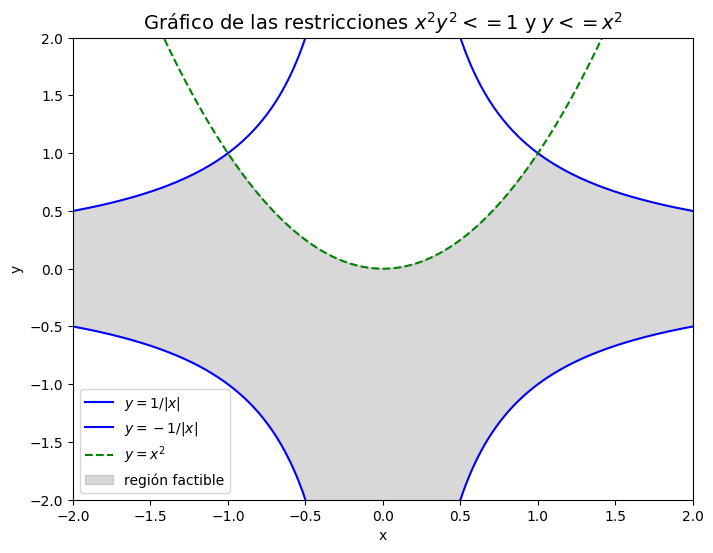

In [50]:
x = np.linspace(-2, 2, 400)  # Rango de x

# Restricción 1: x^2 * y^2 <= 1, es decir, y = ±1/|x|
y_pos = 1/np.abs(x)   # Limite superior de y
y_neg = -1/np.abs(x)  # Limite inferior de y

# Restricción 2: y <= x^2
y_x2 = x**2  # Curva y = x^2

# Considerar solo los valores válidos de y cuando x es diferente de 0
y_pos[~np.isfinite(y_pos)] = np.nan  
y_neg[~np.isfinite(y_neg)] = np.nan 

# Ajustamos las regiones factibles:
y_upper = np.minimum(y_pos, y_x2)  
y_lower = y_neg

# Graficamos
plt.figure(figsize=(8, 6))

plt.plot(x, y_pos, label=r'$y = 1/|x|$', color='blue')
plt.plot(x, y_neg, label=r'$y = -1/|x|$', color='blue')
plt.plot(x, y_x2, label=r'$y = x^2$', color='green', linestyle='--')

# Región factible
plt.fill_between(x, y_lower, y_upper, color='gray', alpha=0.3, label=r'región factible')

# Ajustes
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('x')
plt.ylabel('y')

plt.title('Gráfico de las restricciones $x^2 y^2 <= 1$ y $y <= x^2$', fontsize=14)

plt.legend()
plt.show()


Resolviendolo de forma automatizada con la función programada se tiene que:

In [51]:
# Variables y multiplicadores de Lagrange
x, y, u_1, u_2 = sp.symbols('x y u_1 u_2')

# Función Objetivo
f = x-10*y

# Restricciones
g1 = -x**2 + y            # Restricción 1: -x**2 + y <= 0
g2 = (x**2)*(y**2) - 1       # Restricción 2: (x**2)*(y**2) - 1   <= 0


restricciones = [g1, g2]

# Lagrangiano para P_1
lagrangiano = f + u_1 * g1 + u_2 * g2

# Derivadas del Lagrangiano respecto de x e y
L_x = sp.diff(lagrangiano, x)
L_y = sp.diff(lagrangiano, y)

# Condiciones de KKT para P_1
condiciones_kkt = [
    L_x, L_y,    # Derivadas del Lagrangiano     # Restricciones de factibilidad
    u_1 * g1,       # Ortogonalidad para g1
    u_2 * g2,       # Ortogonalidad para g2
]

# Llamar a la función para resolver P_1
print("Resolviendo el problema:")
resolver_kkt(lagrangiano, restricciones, condiciones_kkt, [x, y], [u_1, u_2], 10**(-8))

Resolviendo el problema:

Todos los puntos:
{x: sqrt(10), y: -sqrt(10)/10, u_1: 0, u_2: -sqrt(10)/2}
{x: -sqrt(10), y: sqrt(10)/10, u_1: 0, u_2: sqrt(10)/2}
{x: -1, y: 1, u_1: 3, u_2: 7/2}
{x: 1, y: 1, u_1: 11/3, u_2: 19/6}
{x: 1/20, y: 1/400, u_1: 10, u_2: 0}

Puntos KKT:
Punto: {x: -sqrt(10), y: sqrt(10)/10, u_1: 0, u_2: sqrt(10)/2}, f(x, y) = -6.32455532033676
Punto: {x: -1, y: 1, u_1: 3, u_2: 7/2}, f(x, y) = -11.0000000000000
Punto: {x: 1, y: 1, u_1: 11/3, u_2: 19/6}, f(x, y) = -9.00000000000000
Punto: {x: 1/20, y: 1/400, u_1: 10, u_2: 0}, f(x, y) = 0.0250000000000000

La solución óptima es: {x: -1, y: 1, u_1: 3, u_2: 7/2}
Valor de la función objetivo en la solución óptima: f(x, y) = -11.0000000000000


Como se puede observar, nos dan los mismos puntos KKT y la misma solución óptima.

A modo de complemento, tambien lo resolvemos como en el apartado a):

In [52]:
# Definimos las variables
x, y, u_1, u_2 = sp.symbols('x y u_1 u_2')

# Función Objetivo
f = x-10*y

# Restricciones
g1 = -x**2 + y            # Restricción 1: -x**2 + y <= 0
g2 = (x**2)*(y**2) - 1       # Restricción 2: (x**2)*(y**2) - 1   <= 0


# Lagrangiano
L = f + u_1 * g1 + u_2 * g2

# Derivadas parciales con respecto de x y de y
L_x = sp.diff(L, x)
L_y = sp.diff(L, y)

print("Derivada parcial de L respecto a x:", L_x)
print("Derivada parcial de L respecto a y:", L_y)

# Resolver el sistema de ecuaciones (L_x = 0, L_y = 0, condiciones de complementariedad y factibilidad)
condiciones_min = [
    L_x,          # Derivada con respecto a x
    L_y,          # Derivada con respecto a y          # Restricción 1          # Restricción 2
    u_1 * g1, # Condición de complementariedad de la restricción 1
    u_2 * g2, # Condición de complementariedad de la restricción 2
]

# Resolvemos y obtenemos los puntos KKT
Puntos = sp.solve(condiciones_min, [x, y, u_1, u_2], dict=True)

# El siguiente paso es evaluar los puntos KKT en la función objetivo para obtener el óptimo

opt_value = float('inf')  # Inicializamos el valor óptimo como infinito
optimal_solution = None  # Variable para almacenar la solución óptima

puntos = []
puntos_kkt = []

# Iteramos sobre todas las soluciones y evaluamos ÚNICAMENTE en puntos KKT factibles, por eficiencia
for sol in Puntos:
    if all (sp.im(sol[var])==0 for var in sol):
        x_val = sp.simplify(sol[x])
        y_val = sp.simplify(sol[y])
        u_1_val = sp.simplify(sol[u_1])
        u_2_val = sp.simplify(sol[u_2])
        #f_value = f.subs({x: x_val, y: y_val}).evalf()
        puntos.append((x_val, y_val, u_1_val, u_2_val))  # Almacena todos los puntos KKT

        # Verifica si el punto KKT es factible
        eps = 1e-8
        if (g1.subs({x: x_val, y: y_val}).evalf() <= eps #restricción 1\
            and g2.subs({x: x_val, y: y_val}).evalf() <= eps # y >= 0\
            and u_1_val >= 0 and u_2_val >= 0):
            f_value = f.subs({x: x_val, y: y_val}).evalf()
            puntos_kkt.append((x_val, y_val, f_value, u_1_val, u_2_val))  # Almacena los puntos KKT factibles

            # Verifica si es el mínimo óptimo
            if f_value < opt_value:
                opt_value = f_value
                optimal_solution = sol

# Puntos
print("\nTodos los puntos:")
for punto in puntos:
    print(f"x = {punto[0]}, y = {punto[1]}, con u_1 = {punto[2]}, u_2 = {punto[3]}")

# Puntos KKT
print("\nPuntos KKT")
for punto in puntos_kkt:
    print(f"x = {punto[0]}, y = {punto[1]}, con f(x, y) = {punto[2]}, u_1 = {punto[3]}, u_2 = {punto[4]}")

# Solución óptima
if optimal_solution:
    print(f"\nLa solución óptima es: x = {optimal_solution[x].evalf()}, y = {optimal_solution[y].evalf()}")
    print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {opt_value}")
    print(f"Multiplicadores: u_1 = {optimal_solution[u_1].evalf()}, u_2 = {optimal_solution[u_2].evalf()}")
else:
    print("No se encontró una solución óptima factible.")

Derivada parcial de L respecto a x: -2*u_1*x + 2*u_2*x*y**2 + 1
Derivada parcial de L respecto a y: u_1 + 2*u_2*x**2*y - 10

Todos los puntos:
x = sqrt(10), y = -sqrt(10)/10, con u_1 = 0, u_2 = -sqrt(10)/2
x = -sqrt(10), y = sqrt(10)/10, con u_1 = 0, u_2 = sqrt(10)/2
x = -1, y = 1, con u_1 = 3, u_2 = 7/2
x = 1, y = 1, con u_1 = 11/3, u_2 = 19/6
x = 1/20, y = 1/400, con u_1 = 10, u_2 = 0

Puntos KKT
x = -sqrt(10), y = sqrt(10)/10, con f(x, y) = -6.32455532033676, u_1 = 0, u_2 = sqrt(10)/2
x = -1, y = 1, con f(x, y) = -11.0000000000000, u_1 = 3, u_2 = 7/2
x = 1, y = 1, con f(x, y) = -9.00000000000000, u_1 = 11/3, u_2 = 19/6
x = 1/20, y = 1/400, con f(x, y) = 0.0250000000000000, u_1 = 10, u_2 = 0

La solución óptima es: x = -1.00000000000000, y = 1.00000000000000
Valor de la función objetivo en la solución óptima: f(x, y) = -11.0000000000000
Multiplicadores: u_1 = 3.00000000000000, u_2 = 3.50000000000000


[(-sqrt(10), sqrt(10)/10, -6.32455532033676, 0, sqrt(10)/2), (-1, 1, -11.0000000000000, 3, 7/2), (1, 1, -9.00000000000000, 11/3, 19/6), (1/20, 1/400, 0.0250000000000000, 10, 0)]


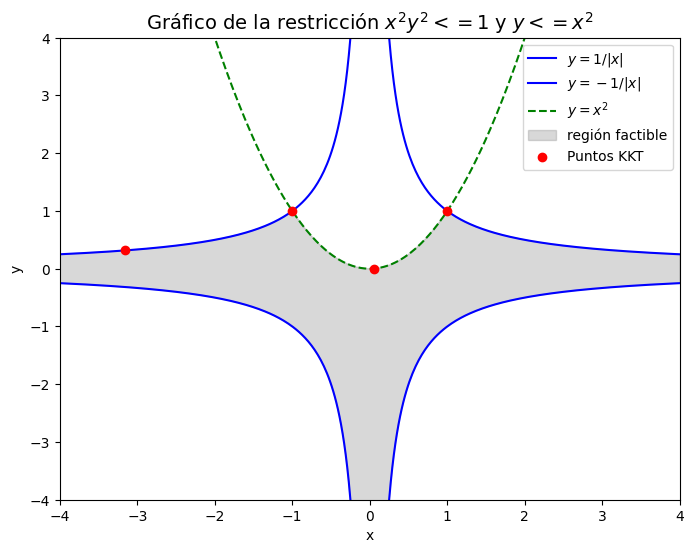

In [53]:
print(puntos_kkt)

x = np.linspace(-4, 4, 400)  # Rango de x

# Restricción 1: x^2 * y^2 <= 1, es decir, y = ±1/|x|
y_pos = 1/np.abs(x)   # Limite superior de y
y_neg = -1/np.abs(x)  # Limite inferior de y

# Restricción 2: y <= x^2
y_x2 = x**2  # Curva y = x^2

# Considerar solo los valores válidos de y cuando x es diferente de 0
y_pos[~np.isfinite(y_pos)] = np.nan  
y_neg[~np.isfinite(y_neg)] = np.nan 

# Ajustamos las regiones factibles:
y_upper = np.minimum(y_pos, y_x2)  
y_lower = y_neg

# Graficamos
plt.figure(figsize=(8, 6))

plt.plot(x, y_pos, label=r'$y = 1/|x|$', color='blue')
plt.plot(x, y_neg, label=r'$y = -1/|x|$', color='blue')
plt.plot(x, y_x2, label=r'$y = x^2$', color='green', linestyle='--')

# Región factible
plt.fill_between(x, y_lower, y_upper, color='gray', alpha=0.3, label=r'región factible')

puntos_kkt_x, puntos_kkt_y = zip(*[(punto[0], punto[1]) for punto in puntos_kkt])  # Extraemos los x y y
plt.scatter(puntos_kkt_x, puntos_kkt_y, color='red', label='Puntos KKT', zorder=5)

# Ajustes
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x')
plt.ylabel('y')

plt.title('Gráfico de la restricción $x^2 y^2 <= 1$ y $y <= x^2$', fontsize=14)

plt.legend()
plt.show()


## Ejercicio 2

Implementa en Python el algoritmo de Zoutendijk.

El algoritmo de Zoutendijk se describe a continuación

$$
\begin{array}{ll}
\text{1. Inicialización:} \\
\quad x^0 \in \mathbb{R}^n, \, g(x^0) \leq 0 \\
\quad k = 0 \\[10pt]

\text{2. Identificación de restricciones activas:} \\
\quad \text{Sea } I = \{ i \in \{1, 2, \dots, m\} \mid g_i(x^k) = 0 \} \\[10pt]

\text{3. Resolución del problema de programación lineal aproximado:} \\
\quad P^k : \begin{cases}
\min \, z \\
\text{sujeto a} \\
\quad \nabla f(x^k)^t d \leq z \\
\quad \nabla g_i(x^k)^t d \leq z \quad \forall i \in I \\
\quad d_j \in [-1, 1] \quad \forall j \in \{1, 2, \dots, n\}
\end{cases} \\[10pt]

\text{Sea } (z^k, d^k) \text{ la solución del problema } P^k. \\[10pt]

\text{if } z^k < 0 \text{ then} \\
\quad d^k \text{ es simultáneamente dirección de descenso y factible} \\
\quad \text{IR AL PASO 4} \\[10pt]

\text{else} \\
\quad \text{No existe una dirección de descenso que sea factible} \\
\quad \text{La solución óptima es } x^k \\
\quad \text{FIN} \\[10pt]

\text{4. Actualización de la solución factible:} \\
\quad \text{Resolver el siguiente problema de optimización sin restricciones} \\
\quad \min_{\lambda \in [0, \lambda_M]} \{ f(x^k + \lambda d^k) \} = f(x^k + \lambda^* d^k) \\
\quad \text{Donde } \lambda_M = \max \{ \lambda \geq 0, \, g_i(x^k + \lambda d^k) \leq 0, \, \forall i \in \{1, 2, \dots, m\} \} \\
\quad x^{k+1} = x^k + \lambda^* d^k \\
\quad k = k + 1 \\
\quad \text{IR AL PASO 2}
\end{array}
$$


A continuación se implementa el algoritmo. Se hace uso del algoritmo de la sección áurea implementado en la práctica 1 para resolver el problema de optimización de encontrar el mínimo $\lambda \in [0,\lambda_M]$.

Algoritmo de la sección áurea:

In [54]:
def SeccionAurea(f,a,b,eps):
    phi = (1 + 5 ** 0.5) / 2
    phiInv = 1/phi
    I0 = b-a
    x1 = b-phiInv*I0
    x2 = a+phiInv*I0
    f1 = f(x1)
    f2 = f(x2)

    # Encabezado de la tabla donde se registrarán las iteraciones
    #print(f"{'Iter':<5} {'a':<10} {'b':<10} {'x1':<10} {'x2':<10} {'f(x1)':<10} {'f(x2)':<10}")
    #print("-"*70)
    iteracion = 0

    while (b-a) > eps:
       # print(f"{iteracion:<5} {a:<10.5f} {b:<10.5f} {x1:<10.5f} {x2:<10.5f} {f1:<10.5f} {f2:<10.5f}")

        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = b - phiInv*(b-a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + phiInv*(b-a)
            f2 = f(x2)
            
        iteracion += 1
    return (a+b)/2 

Zoutendijk:

In [55]:
def zoutendijk(x_ini, f, grad_f, restricciones, tol):
    x, y = sp.symbols('x y')

    # Verificar si el punto inicial es factible
    factible = all(rest.subs({x: x_ini[0], y: x_ini[1]}).evalf() <= tol for rest in restricciones)
    if not factible:
        print("El punto inicial no es factible. No se puede aplicar el algoritmo.")
        return None

    print("El punto inicial es factible. Iniciando el algoritmo de Zoutendijk.")
    x_k = x_ini
    iter_count = 0

    while True:
        print(f"\nIteración {iter_count}: Punto actual {x_k}")

        # Gradiente de f en el punto actual
        grad_eval = grad_f.subs({x: x_k[0], y: x_k[1]}).evalf()
        grad_x, grad_y = grad_eval[0], grad_eval[1]

        # Identificación de restricciones activas
        res_activas = []
        for rest in restricciones:
            rest_value = rest.subs({x: x_k[0], y: x_k[1]}).evalf()
            if abs(rest_value) <= tol:
                res_activas.append(rest)

        # Resolver el problema lineal aproximado
        problem = plp.LpProblem("buscar_direccion", plp.LpMinimize)
        z = plp.LpVariable("z", lowBound=None, upBound=None, cat="Continuous")
        d1 = plp.LpVariable("d1", lowBound=-1, upBound=1, cat="Continuous")
        d2 = plp.LpVariable("d2", lowBound=-1, upBound=1, cat="Continuous")

        # Función objetivo
        problem += z

        # Restricción de gradiente
        problem += grad_x * d1 + grad_y * d2 - z <= 0, "Restricción_gradiente_f"

        # Restricciones activas
        for i, rest in enumerate(res_activas, start=1):
            grad_g_i_x = sp.diff(rest, x)
            grad_g_i_y = sp.diff(rest, y)
            grad_g_i_val = {x: x_k[0], y: x_k[1]}
            grad_g_i_x_val = grad_g_i_x.subs(grad_g_i_val).evalf()
            grad_g_i_y_val = grad_g_i_y.subs(grad_g_i_val).evalf()
            problem += grad_g_i_x_val * d1 + grad_g_i_y_val * d2 <= 0, f"Restricción_g{i}"

        # Resolver el problema
        status = problem.solve()
        if plp.LpStatus[problem.status] != 'Optimal':
            print("No existe una dirección de descenso factible")
            print(f"La solución óptima es {x_k}")
            return x_k

        # Dirección de descenso
        d = [d1.varValue, d2.varValue]
        z_val = z.varValue
        if z_val >= 0:
            print("No existe una dirección de descenso factible")
            print(f"La solución óptima es {x_k}")
            return x_k

        print(f"Dirección de descenso factible: {d}")

        # Cálculo de lambda máximo
        lambda_max = float('inf')
        lam = sp.symbols('lam', real=True)
        for rest in restricciones:
            expr = rest.subs({x: x_k[0] + d[0] * lam, y: x_k[1] + d[1] * lam})
            sol = sp.solve(expr, lam)
            valid_lambdas = [l.evalf() for l in sol if l.is_real and l >= 0]
            if valid_lambdas:
                min_lam = min(valid_lambdas)
                lambda_max = min(lambda_max, min_lam)

        if lambda_max == float('inf') or lambda_max <= 0:
            lambda_max = 0.1  # Pequeño paso predeterminado para evitar que el algoritmo se estanque


        print(f"Lambda máximo: {lambda_max}")

        # Resolver el problema de optimización unidimensional para λ* usando SeccionAurea
        def f_lambda(lam_value):
            x_new = [x_k[0] + lam_value * d[0], x_k[1] + lam_value * d[1]]
            return f(x_new)

        lambda_star = SeccionAurea(f_lambda, 0, lambda_max, tol)

        print(f"Lambda*: {lambda_star}")

        # Actualización de la solución
        x_k = [x_k[0] + lambda_star * d[0], x_k[1] + lambda_star * d[1]]
        iter_count += 1
        
        # Verificar criterio de convergencia
        grad_norm = grad_x**2 + grad_y**2
        if grad_norm < tol**2 or abs(f(x_k) - f([-1, 1])) < tol:
            print(f"Convergencia alcanzada en la iteración {iter_count}.")
            print(f"Solución óptima: {x_k}")
            return x_k


        # Límite máximo de iteraciones
        if iter_count > 20:
            print("Número máximo de iteraciones alcanzado.")
            return x_k


Después:

a) Aplícalo al problema $P_2$, partiendo de diferentes puntos. Sugiero los siguientes:
$$
(-0.5,-0.5),(0.5,0.5),(2,1)
$$

Para el punto $(-0.5,-0.5)$:

In [56]:
# Definimos las restricciones y la función objetivo
x, y = sp.symbols('x y')
restricciones = [-x**2 + y, (x - 1)**2 + y - 5, -y]
f = lambda x: 2 * x[0] - x[1]  # Función objetivo
grad_f = sp.Matrix([2, -1])  # Gradiente constante de f
# gradx = 2
# grady = -1
# grad_f = [gradx,grady]

# Punto inicial
x_ini = [-0.5,-0.5] 

# Ejecutamos el algoritmo
resultado = zoutendijk(x_ini, f, grad_f, restricciones, tol = 1e-6)
print("\nResultado final:", resultado)

El punto inicial no es factible. No se puede aplicar el algoritmo.

Resultado final: None


Coherente. Si el punto inicial no es factible el algoritmo no puede ser ejecutado.

Para el punto $(0.5,0.5)$:

In [57]:
# Definimos las restricciones y la función objetivo
x, y = sp.symbols('x y')
restricciones = [-x**2 + y, (x - 1)**2 + y - 5, -y]
f = lambda x: 2 * x[0] - x[1]  # Función objetivo
grad_f = sp.Matrix([2, -1])  # Gradiente constante de f
# gradx = 2
# grady = -1
# grad_f = [gradx,grady]

# Punto inicial
x_ini = [0.5,0.5] 

# Ejecutamos el algoritmo
resultado = zoutendijk(x_ini, f, grad_f, restricciones, tol = 1e-6)
print("\nResultado final:", resultado)

El punto inicial no es factible. No se puede aplicar el algoritmo.

Resultado final: None


Igual que antes.

Para el punto $(2,1)$:

In [58]:
# Definimos las restricciones y la función objetivo
x, y = sp.symbols('x y')
restricciones = [-x**2 + y, (x - 1)**2 + y - 5, -y]
f = lambda x: 2 * x[0] - x[1]  # Función objetivo
grad_f = sp.Matrix([2, -1])  # Gradiente constante de f
# gradx = 2
# grady = -1
# grad_f = [gradx,grady]

# Punto inicial
x_ini = [2,1] 

# Ejecutamos el algoritmo
resultado = zoutendijk(x_ini, f, grad_f, restricciones, tol = 1e-6)
print("\nResultado final:", resultado)

El punto inicial es factible. Iniciando el algoritmo de Zoutendijk.

Iteración 0: Punto actual [2, 1]
Dirección de descenso factible: [-1.0, 1.0]
Lambda máximo: 0.697224362268005
Lambda*: 0.697223871711961

Iteración 1: Punto actual [1.30277612828804, 1.69722387171196]
Dirección de descenso factible: [-1.0, 1.0]
Lambda máximo: 4.90556043784776E-7
Lambda*: 2.45278021892388E-7

Iteración 2: Punto actual [1.30277588301002, 1.69722411698998]
Dirección de descenso factible: [0.38379587, 1.0]
Lambda máximo: 2.08564348112025
Lambda*: 2.08564313470801

Iteración 3: Punto actual [2.10323710440481, 3.78286725169800]
Dirección de descenso factible: [-1.0, 1.0]
Lambda máximo: 0.126120967421558
Lambda*: 0.126120591526781

Iteración 4: Punto actual [1.97711651287802, 3.90898784322478]
Dirección de descenso factible: [-1.0, 1.0]
Lambda máximo: 3.75894777580166E-7
Lambda*: 1.87947388790083E-7

Iteración 5: Punto actual [1.97711632493064, 3.90898803117217]
Dirección de descenso factible: [0.25289357, 1

Se observa que el algoritmo funciona correctamente empezando desde el punto $(2,1)$, puesto que alcanza el punto $KKT$ $(2,4)$. Esto es coherente con la forma de la región factible. Si recordamos, la región factible de $P_2$ estaba dividida para $x \geq 0$ y $x < 0$. El punto óptimo del problema era el $(-1,1)$ mientras mientras que los otros dos puntos $KKT$ no óptimos se encontraban en la región $x>0$ puesto que eran $(1,1)$ y $(2,4)$. Al comenzar el algoritmo en la región $x>0$, no puede alcanzar el óptimo global pero sí alcanza el óptimo de esa región, que es el $(2,4)$.

b) Aplícalo al problema de Bazaraa visto antes.

In [59]:
# Definimos las restricciones y la función objetivo
x, y = sp.symbols('x y')
restricciones = [
    x + 5 * y - 5,  # x + 5y <= 5
    2 * x**2 - y,   # 2x^2 - y <= 0
    -x,             # x >= 0 
    -y              # y >= 0 
]
f = lambda x: 2 * x[0]**2 + 2 * x[1]**2 - 2 * x[0] * x[1] - 4 * x[0] - 6 * x[1]  # Función objetivo
grad_f = sp.Matrix([4 * x - 2 * y - 4, 4 * y - 2 * x - 6])  # Gradiente

# Punto inicial
x_ini = [0.4,0.6]

# Ejecutamos el algoritmo
resultado = zoutendijk(x_ini, f, grad_f, restricciones, tol = 1e-6)
print("\nResultado final:", resultado)

El punto inicial es factible. Iniciando el algoritmo de Zoutendijk.

Iteración 0: Punto actual [0.4, 0.6]
Dirección de descenso factible: [1.0, 1.0]
Lambda máximo: 0.253112887414927
Lambda*: 0.253112421179130

Iteración 1: Punto actual [0.653112421179129, 0.853112421179129]
Dirección de descenso factible: [0.38278249, 1.0]
Lambda máximo: 0.00160169981545113
Lambda*: 0.00160133694727164

Iteración 2: Punto actual [0.653725384923135, 0.854713758126401]
Dirección de descenso factible: [0.38242358, 1.0]
Lambda máximo: 0.0000341102237536305
Lambda*: 0.0000337471846129128

Iteración 3: Punto actual [0.653738290642290, 0.854747505311014]
Dirección de descenso factible: [0.38241603, 1.0]
Lambda máximo: 0.00000495221639823905
Lambda*: 0.00000459095708063448

Iteración 4: Punto actual [0.653740046297870, 0.854752096268095]
Dirección de descenso factible: [0.382415, 1.0]
Lambda máximo: 0.00000186145122514051
Lambda*: 0.00000150594567533874

Iteración 5: Punto actual [0.653740622194086, 0.85475360

Partiendo del punto inicial factible $(0.4,0.6)$ algoritmo converge hacia el único punto $KKT$ y óptimo del problema $(0.65,0.85)$

## Ejercicio 3

Continuando el ejercicio 2 de la práctica anterior, ajusta la recta de regresión para los datos de dicho ejercicio fijando como criterio a minimizar la distancia ortogonal entre la curva y la nube de puntos.

Dado el conjunto de datos:

$$
\begin{align*}
(x^1, y^1) &= (-0.5,\ -0.5) \\
(x^2, y^2) &= (0.5,\ 0.5) \\
(x^3, y^3) &= (2,\ 1)
\end{align*}
$$

Queremos ajustar una recta de regresión de la forma:

$$
y = \alpha + \beta x
$$

Minimizando la suma de las distancias ortogonales al cuadrado entre los puntos y la recta. Introducimos las variables de desviación horizontal $\delta^i$ y vertical $\epsilon_i$ para cada punto $i$:

- $\delta_i$: Error horizontal (en $x$)
- $\epsilon_i$: Error vertical (en $y$)

El problema de optimización se formula como:

### Función Objetivo:

$$
\min_{\alpha, \beta} \quad S(\alpha, \beta) = \sum_{i=1}^{3} \left( \delta_i^2 + \epsilon_i^2 \right)
$$

### Sujeto a las Restricciones:

$$
y^i = \alpha + \beta (x^i + \delta^i) + \epsilon_i \quad \forall\ i = 1, 2, 3
$$

Donde:

- $\alpha, \beta$ son los parámetros de la recta (no restringidos).
- $\delta_i, \epsilon_i$ son variables reales (pueden ser positivas o negativas).


#### Se resuelve de tres formas diferentes: con la función $odr$ de $scipy$, con $minimize$, y con la función programada en el ejercicio 1 de $KKT$

### Con $scipy.odr$

Podemos comenzar definiendo una función que sea la función lineal del modelo:

In [60]:
def modelo_lineal(coef, x):
    return coef[0] * x + coef[1]

Representa $$ y = \beta \cdot x + \alpha $$

A continuación se definen los datos

In [61]:
x = np.array([-0.5, 0.5, 2])
y = np.array([-0.5, 0.5, 1])

Como siguiente paso se aplica la regresión ortogonal haciendo uso del paquete $scipy$ con la función $odr$.

In [62]:
data = odr.RealData(x, y) 

model = odr.Model(modelo_lineal) # Modelo lineal ortogonal

odr = odr.ODR(data, model, beta0=[1.0,0.0]) # Parámetros iniciales de búsqueda [1,0]

# Regresión ortogonal
res = odr.run()

Obtenemos los parámetros ajustados:

In [63]:
pendiente = res.beta[0]
intercepto = res.beta[1]
print(f"Pendiente: {pendiente}")
print(f"Intercepto: {intercepto}")

Pendiente: 0.5936338342375109
Intercepto: -0.06242274771378001


$$
\begin{cases}
    \hat{\beta} = 0.593633 \\
    \hat{\alpha} = -0.062422
\end{cases}
$$

Finalmente, podemos visualizar la recta ajustada

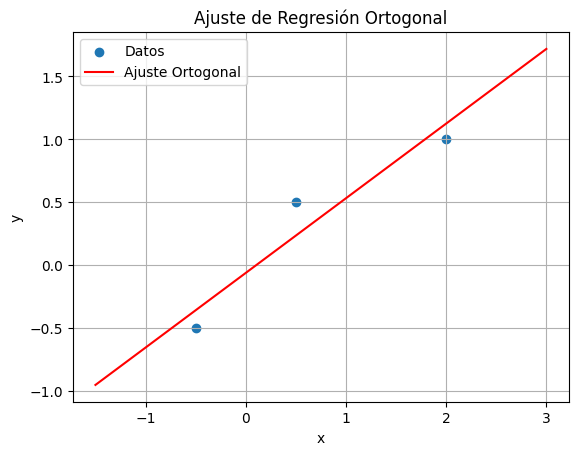

In [64]:
x_aj = np.linspace(min(x) - 1, max(x) + 1, 100)
y_aj = modelo_lineal([pendiente, intercepto], x_aj)

plt.scatter(x, y, label='Datos')
plt.plot(x_aj, y_aj, 'r', label='Ajuste Ortogonal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ajuste de Regresión Ortogonal')
plt.legend()
plt.grid(True)
plt.show()


### Con $minimize$

Valor mínimo de la función objetivo: 0.07833945774700381
Alpha: -0.06259814006881852
Beta: 0.5937574389373066
Valores de delta_i:
delta_1: -0.06158259259140474
delta_2: 0.11669307278689149
delta_3: -0.05494726316339259
Valores de epsilon_i:
epsilon_1: -0.10395773095663277
epsilon_2: 0.19643211921074172
epsilon_3: -0.09229181863987893


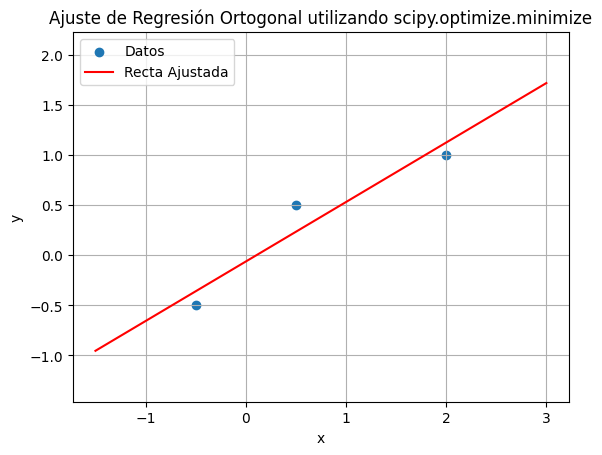

In [65]:
# Datos de entrada
x = np.array([-0.5, 0.5, 2.0])
y = np.array([-0.5, 0.5, 1.0])
m = len(y)

# Función objetivo
def objetivo(vars):
    delta = vars[0:m]
    epsilon = vars[m:2*m]
    return np.sum(delta**2 + epsilon**2)

# Restricciones de igualdad
def restr_i(vars, i):
    alpha = vars[-2]
    beta = vars[-1]
    delta_i = vars[i]
    epsilon_i = vars[m + i]
    return y[i] - (alpha + beta * (x[i] + delta_i) + epsilon_i)

# Vector inicial de variables [delta_i, epsilon_i, alpha, beta]
x0 = np.zeros(2*m + 2)

# Restricciones
restr = []
for i in range(m):
    restr.append({
        'type': 'eq',
        'fun': restr_i,
        'args': (i,)
    })

# Resolvemos el problema con minimize
result = minimize(objetivo, x0, method='SLSQP', constraints=restr)

# Resultados
delta_opt = result.x[0:m]
epsilon_opt = result.x[m:2*m]
alpha_opt = result.x[-2]
beta_opt = result.x[-1]

print(f"Valor mínimo de la función objetivo: {result.fun}")
print(f"Alpha: {alpha_opt}")
print(f"Beta: {beta_opt}")
print("Valores de delta_i:")
for i in range(m):
    print(f"delta_{i+1}: {delta_opt[i]}")
print("Valores de epsilon_i:")
for i in range(m):
    print(f"epsilon_{i+1}: {epsilon_opt[i]}")

# Gráfica
x_aj = np.linspace(min(x) - 1, max(x) + 1, 100)
y_aj = alpha_opt + beta_opt * x_aj

plt.scatter(x, y, label='Datos')
plt.plot(x_aj, y_aj, 'r', label='Recta Ajustada')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ajuste de Regresión Ortogonal utilizando scipy.optimize.minimize')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


### Aplicando el algoritmo $KKT$ del ejercicio 1.

En el ejercicio 1 se definió la siguiente función:

In [66]:
def resolver_kkt(lagrangiano, restricciones, condiciones_kkt, variables, multiplicadores, eps):
    # Sistema de ecuaciones
    soluciones = sp.solve(condiciones_kkt, variables + multiplicadores, dict=True)

    valor_optimo = float('inf') # Inicialización del óptimo
    solucion_optima = None
    puntos = []
    puntos_kkt = []
    eps = 1e-8  # Tolerancia para la factibilidad

    for sol in soluciones:
        # Solo cogemos las soluciones reales
        if all (sp.im(sol[var])==0 for var in sol):
            # Se evalúan las variables en la solución actual
            valores_solucion = {var: sp.simplify(sol[var]) for var in variables + multiplicadores}
            puntos.append(valores_solucion)

            # Verificación de si el punto es factible
            factible = True
            for cond in condiciones_kkt:
                residuo = cond.lhs.subs(valores_solucion) - cond.rhs.subs(valores_solucion)
                if abs(residuo.evalf()) > eps:
                    factible = False
                    break

            if factible:
                valor_objetivo = lagrangiano.subs(valores_solucion).evalf()
                puntos_kkt.append((valores_solucion, valor_objetivo))

                # Si es la mejor solución encontrada, se actualiza el valor y la solución
                if valor_objetivo < valor_optimo:
                    valor_optimo = valor_objetivo
                    solucion_optima = valores_solucion

    # Puntos KKT
    print("\nTodos los puntos:")
    for punto in puntos:
        print(punto)

    # Puntos KKT factibles
    print("\nPuntos KKT:")
    for punto, valor in puntos_kkt:
        print(f"Punto: {punto}, f(x, y) = {valor}")

    # Solución óptima
    if solucion_optima:
        print(f"\nLa solución óptima es: {solucion_optima}")
        print(f"Valor de la función objetivo en la solución óptima: f(x, y) = {valor_optimo}")
    else:
        print("No se encontró una solución óptima factible.")

    return solucion_optima


Podemos aplicar esta función para resolver el problema de regresión ortogonal:

In [67]:
# Variables simbólicas
alpha, beta = sp.symbols('alpha beta')
delta1, delta2, delta3 = sp.symbols('delta1 delta2 delta3')
epsilon1, epsilon2, epsilon3 = sp.symbols('epsilon1 epsilon2 epsilon3')
lambda1, lambda2, lambda3 = sp.symbols('lambda1 lambda2 lambda3')

variables = [alpha, beta, delta1, delta2, delta3, epsilon1, epsilon2, epsilon3]
multiplicadores = [lambda1, lambda2, lambda3]

# Datos
x1, y1 = -0.5, -0.5
x2, y2 = 0.5, 0.5
x3, y3 = 2.0, 1.0

# Función objetivo
S = delta1**2 + delta2**2 + delta3**2 + epsilon1**2 + epsilon2**2 + epsilon3**2

# Lagrangiano
L = S + lambda1 * (alpha + beta * (x1 + delta1) + epsilon1 - y1) \
      + lambda2 * (alpha + beta * (x2 + delta2) + epsilon2 - y2) \
      + lambda3 * (alpha + beta * (x3 + delta3) + epsilon3 - y3)

# Derivadas parciales (condiciones KKT)
grad_L = [
    sp.Eq(sp.diff(L, alpha), 0),     # Derivada respecto a alpha
    sp.Eq(sp.diff(L, beta), 0),      # Derivada respecto a beta
    sp.Eq(sp.diff(L, delta1), 0),    # Derivada respecto a delta1
    sp.Eq(sp.diff(L, delta2), 0),    # Derivada respecto a delta2
    sp.Eq(sp.diff(L, delta3), 0),    # Derivada respecto a delta3
    sp.Eq(sp.diff(L, epsilon1), 0),  # Derivada respecto a epsilon1
    sp.Eq(sp.diff(L, epsilon2), 0),  # Derivada respecto a epsilon2
    sp.Eq(sp.diff(L, epsilon3), 0)   # Derivada respecto a epsilon3
]

# Restricciones de igualdad
restricciones = [
    sp.Eq(alpha + beta * (x1 + delta1) + epsilon1 - y1, 0),
    sp.Eq(alpha + beta * (x2 + delta2) + epsilon2 - y2, 0),
    sp.Eq(alpha + beta * (x3 + delta3) + epsilon3 - y3, 0)
]

# Unir las condiciones KKT
condiciones_kkt = grad_L + restricciones

# Resolvemos el sistema de ecuaciones
solucion_optima = resolver_kkt(L, restricciones, condiciones_kkt, variables, multiplicadores, eps=1e-8)


Todos los puntos:
{alpha: -0.0624220658267677, beta: 0.593633098740152, delta1: -0.0617868982779946, delta2: 0.116586953519484, delta3: -0.0548000552414897, epsilon1: -0.104082636916848, epsilon2: 0.196395641966246, epsilon3: -0.0923130050493985, lambda1: 0.208165273833696, lambda2: -0.392791283932493, lambda3: 0.184626010098797}
{alpha: 1.45636145976616, beta: -1.68454218964924, delta1: 1.22845356494466, delta2: 0.0500797131471824, delta3: -1.27853327809184, epsilon1: -0.729250696416485, epsilon2: -0.0297289752995798, epsilon3: 0.758979671716065, lambda1: 1.45850139283297, lambda2: 0.0594579505991596, lambda3: -1.51795934343213}

Puntos KKT:
Punto: {alpha: -0.0624220658267677, beta: 0.593633098740152, delta1: -0.0617868982779946, delta2: 0.116586953519484, delta3: -0.0548000552414897, epsilon1: -0.104082636916848, epsilon2: 0.196395641966246, epsilon3: -0.0923130050493985, lambda1: 0.208165273833696, lambda2: -0.392791283932493, lambda3: 0.184626010098797}, f(x, y) = 0.07833931897638

Se obtienen los mismos $\alpha$ y $\beta$ óptimos que antes, como era de esperar.

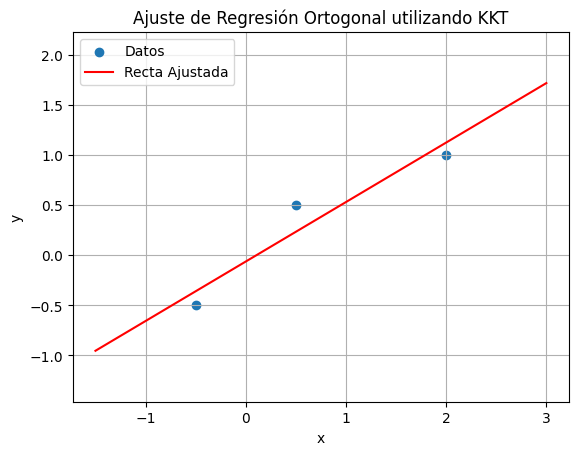

In [68]:
# Datos originales
x_data = np.array([x1, x2, x3])
y_data = np.array([y1, y2, y3])

# Valores óptimos
alpha_opt = solucion_optima[alpha]
beta_opt = solucion_optima[beta]

# Generar puntos para la recta ajustada
x_fit = np.linspace(min(x_data) - 1, max(x_data) + 1, 100)
y_fit = alpha_opt + beta_opt * x_fit

# Graficar
plt.scatter(x_data, y_data, label='Datos')
plt.plot(x_fit, y_fit, 'r', label='Recta Ajustada')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ajuste de Regresión Ortogonal utilizando KKT')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()